# Classical LSTM-Based model for Weather Prediction on Jena Climate Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
from torch.optim import Adam, AdamW, lr_scheduler

## Dataset

In [5]:
df = pd.read_csv('./jena_climate_2009_2016.csv')

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
train_fraction = int(0.72 * df.shape[0])

In [8]:
def Normalize(data, split):
    mean = data[:split].mean(axis=0)
    std = data[:split].std(axis=0)
    return (data - mean) / std # normalize the dataset 

In [9]:
features = df[[df.columns[i+1] for i in [0, 1, 5, 7, 8, 10, 11]]]
features.index = df["Date Time"]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [10]:
features = Normalize(features.values, train_fraction)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.951438,-2.007202,-1.325129,-0.788750,-1.505680,2.245423,-0.730788
1,0.957517,-2.052433,-1.338173,-0.790835,-1.524244,2.295704,-0.934113
2,0.952653,-2.064031,-1.340782,-0.792921,-1.527957,2.306496,-1.281733
3,0.950222,-2.040836,-1.334260,-0.795007,-1.513106,2.280742,-1.183350
4,0.950222,-2.036197,-1.332955,-0.795007,-1.513106,2.276082,-1.196468


In [11]:
X_train = features.loc[:train_fraction-1]
X_valid = features.loc[train_fraction:]

X_train = X_train[range(7)].values
y_train = np.array(features.iloc[792: 792 + train_fraction][[1]])

### Validation Dataset

In [12]:
valid_end = len(X_valid) - 792
valid_start = train_fraction + 792

In [13]:
X_valid = X_valid.iloc[:valid_end][range(7)].values
y_valid = np.array(features.iloc[valid_start:][[1]])

### PyTorch Dataset

In [14]:
class TimeseriesDataset(Dataset):
    def __init__(self, X, y, sequence_length: int=240, sampling_rate: int=6):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.sequence_length = sequence_length
        self.sampling_rate = sampling_rate
        self.indices = [i for i in range(0, self.X.shape[0] - self.sequence_length, self.sampling_rate)]

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start_idx = self.indices[idx]
        end_idx = start_idx + self.sequence_length
        return self.X[start_idx:end_idx], self.y[end_idx-1]

In [15]:
WeatherDataset = TimeseriesDataset(X_train, y_train)

In [16]:
print(f"Length of dataset, {len(WeatherDataset)}")

Length of dataset, 50426


In [17]:
WeatherLoader = DataLoader(WeatherDataset, batch_size=256, shuffle=False)

In [18]:
for batch in WeatherLoader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([256, 240, 7]) torch.Size([256, 1])


In [19]:
ValidDataset = TimeseriesDataset(X_valid, y_valid)

In [20]:
print(f"Length of validation dataset, {len(ValidDataset)}")

Length of validation dataset, 19454


In [21]:
ValidLoader = DataLoader(ValidDataset, batch_size=256, shuffle=False)

## Basic LSTM Model


Simple LSTM Model that we are going to compare to the QuLTSF Model

In [69]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        lookback_window_size,
        forecast_window_size,
        hidden_size
    ):
        super(LSTMModel, self).__init__()
        self.lookback_window_size = lookback_window_size
        self.forecast_window_size = forecast_window_size

        self.input_layer = nn.Linear(lookback_window_size, hidden_size)
        self.c_layer = nn.LSTM(hidden_size, 7)
        self.output_layer = nn.Linear(7, forecast_window_size)

    def forward(self, batch_input):
        x = batch_input.permute(0, 2, 1)
        x = self.input_layer(x)
        x, (_, _) = self.c_layer(x)
        x = F.adaptive_avg_pool1d(x, output_size=1).squeeze(-1)
        x = self.output_layer(x)
        return x

In [70]:
Milner = LSTMModel(
    lookback_window_size = 240,
    forecast_window_size = 1,
    hidden_size = 64,
)

Milner

LSTMModel(
  (input_layer): Linear(in_features=240, out_features=64, bias=True)
  (c_layer): LSTM(64, 7)
  (output_layer): Linear(in_features=7, out_features=1, bias=True)
)

## Training the Model

In [71]:
import timeit

In [72]:
class EarlyStopping:
    def __init__(self):
        self.patience = 5
        self.mindelta = 1e-4
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [73]:
optimizer = Adam(Milner.parameters(), lr=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

loss_fn = nn.HuberLoss(delta=1.5)
#loss_fn = nn.MSELoss()

early_stopping = EarlyStopping()

In [74]:
EPOCHS = 50

TRAIN_LOSS_LIST = []
VAL_LOSS_LIST = []

In [75]:
for epoch in range(EPOCHS):
    start = timeit.default_timer()
    train_Loss = 0.0
    
    for step, (X_batch, y_batch) in enumerate(WeatherLoader):
        logits = Milner(X_batch)
        loss = loss_fn(logits, y_batch)
        Milner.zero_grad()
        loss.backward()
        optimizer.step()
        train_Loss += loss.item()

    train_Loss /= (step+1)
    TRAIN_LOSS_LIST.append(train_Loss)
    Milner.eval()

    val_Loss = 0.0
    with torch.no_grad():
        for step, (X_batch, y_batch) in enumerate(ValidLoader):
            logits = Milner(X_batch)
            loss = loss_fn(logits, y_batch)
            val_Loss += loss.item()

    val_Loss /= (step + 1)
    VAL_LOSS_LIST.append(val_Loss)
    scheduler.step(val_Loss)

    end = timeit.default_timer()

    if not ((epoch+1) % 5):
        print(f"Epoch [{epoch+1}/{EPOCHS}] ({end-start:.3f}s), Train Loss: {train_Loss:.4f}, Val Loss: {val_Loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if early_stopping(val_Loss):
        print("Early Stopping: Training Ended")
        break

Epoch [5/50] (3.675s), Train Loss: 0.2665, Val Loss: 0.2337, LR: 0.000100
Epoch [10/50] (3.698s), Train Loss: 0.2120, Val Loss: 0.1927, LR: 0.000100
Epoch [15/50] (3.712s), Train Loss: 0.1860, Val Loss: 0.1781, LR: 0.000100
Epoch [20/50] (3.765s), Train Loss: 0.1764, Val Loss: 0.1729, LR: 0.000100
Epoch [25/50] (3.691s), Train Loss: 0.1708, Val Loss: 0.1713, LR: 0.000100
Epoch [30/50] (3.683s), Train Loss: 0.1692, Val Loss: 0.1750, LR: 0.000100
Epoch [35/50] (3.737s), Train Loss: 0.1639, Val Loss: 0.1687, LR: 0.000010
Early Stopping: Training Ended


Plot a graph of loss.

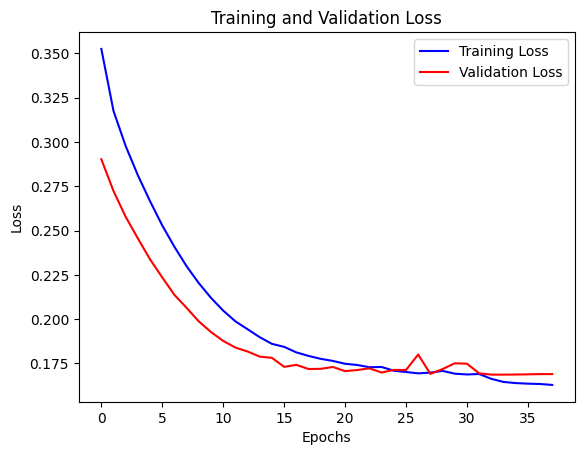

In [76]:
plt.figure()
plt.plot(range(len(TRAIN_LOSS_LIST)), TRAIN_LOSS_LIST, "b", label="Training Loss")
plt.plot(range(len(VAL_LOSS_LIST)), VAL_LOSS_LIST, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
def show_plot(plot_data, delta, title):
    plt.figure(figsize=(6, 3))
    
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta: future = delta
    else: future = 0

    for i, val in enumerate(plot_data):
        if i: plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else: plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")

    prediction_last = plot_data[2][-1]  # Model prediction at the last timestep
    actual_last = plot_data[1][-1]      # True value at the last timestep
    difference = prediction_last - actual_last  # Difference between prediction and actual value

    plt.title(title + f'\nDifference: {difference:.6f}')
    plt.show()
    return 

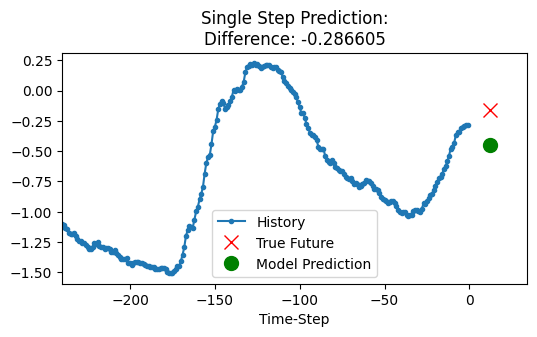

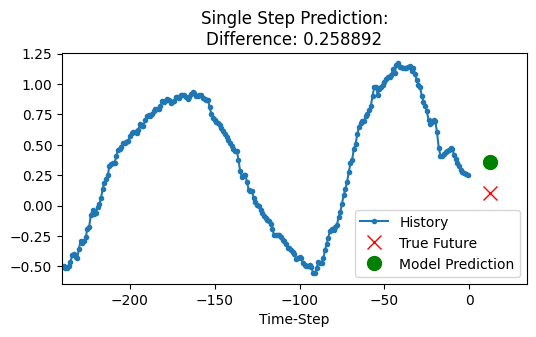

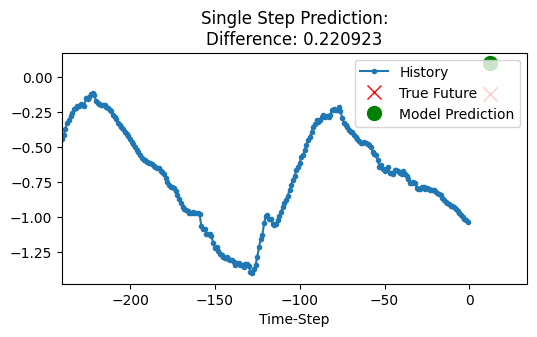

In [80]:
examples = 3

for X_batch, y_batch in ValidLoader:
    Milner.eval()
    with torch.no_grad():
        predictions = Milner(X_batch)

    if np.random.random() >= 0.95:
        examples -= 1
    
        show_plot(
            [X_batch[0][:, 1].numpy(), y_batch[0].numpy(), predictions[0]],
            delta = 12,
            title = f"Single Step Prediction:"
        )

    if not examples: break